# Example 5. Vanilla Variational Autoencoder (vVAE)

In [1]:
import sys

sys.path.append('..')   # add gojo path

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

# GOJO libraries
from gojo import deepl
from gojo import plotting
from gojo import core

DEVICE = 'cuda'

## Data loading

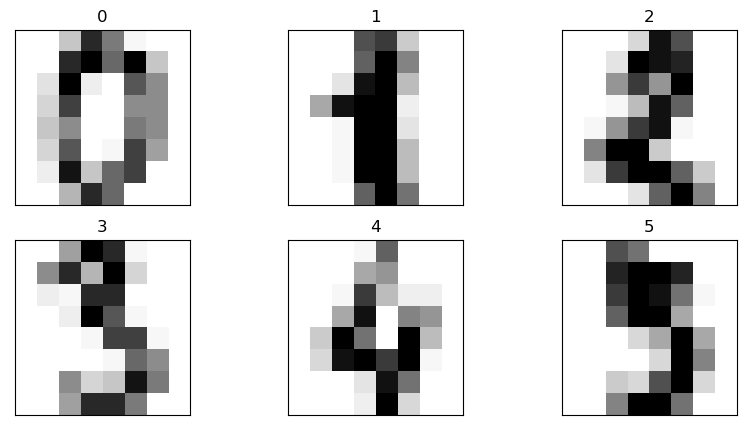

In [2]:
# load the input dataset from (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)
data = datasets.load_digits()

# convert the flatten data back to an image
X = np.reshape(data['data'], (data['data'].shape[0], 1, 8, 8)) / 16

# extract associated labels
labels = data['target']

# plot some examples
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X[i, 0], cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(labels[i])

In [3]:
# separate train/test data
# split Xs and Ys in training and validation
X_train, X_test, labels_train, labels_test = train_test_split(
    X, labels, train_size=0.8, random_state=1997, shuffle=True, stratify=labels)

X_train, X_valid, labels_train, labels_valid = train_test_split(
    X_train, labels_train, train_size=0.8, random_state=1997, 
    shuffle=True, stratify=labels_train)


print(X_train.shape, X_valid.shape, X_test.shape)

# create the dataloaders
train_dl = DataLoader(
    deepl.loading.TorchDataset(X=X_train), 
    batch_size=128, shuffle=True)

valid_dl = DataLoader(
    deepl.loading.TorchDataset(X=X_valid), 
    batch_size=X_valid.shape[0], shuffle=False)

(1149, 1, 8, 8) (288, 1, 8, 8) (360, 1, 8, 8)


## Model training

In [4]:
# create a simple variational autoencoder
model = deepl.models.VAE(
    encoder=torch.nn.Sequential(
        torch.nn.Conv2d(1, 8, (3, 3)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(8),
        torch.nn.Dropout(0.1),

        torch.nn.Conv2d(8, 16, (3, 3)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(16),
        torch.nn.Dropout(0.1),

        torch.nn.Conv2d(16, 8, (3, 3)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(8),
        torch.nn.Dropout(0.1),

        torch.nn.Flatten(),
    ),
    encoder_out_dim=32,
    decoder=torch.nn.Sequential(
        torch.nn.Unflatten(1, (8, 2, 2)),

        torch.nn.ConvTranspose2d(8, 16, kernel_size=(3, 3)),
        torch.nn.ReLU(),

        torch.nn.ConvTranspose2d(16, 8, kernel_size=(3, 3)),
        torch.nn.ReLU(),

        torch.nn.ConvTranspose2d(8, 1, kernel_size=(3, 3)),
        torch.nn.ReLU(),
    ),
    decoder_in_dim=32,
    latent_dim=10
)

# with torch.no_grad():
#     tX = torch.Tensor(X[:12])
#     out = model(tX)
# out[0].shape, out[1]['mu'].shape, out[1]['logvar'].shape

In [5]:
output = deepl.fitNeuralNetwork(
    deepl.iterUnsupervisedEpoch,
    model=model,
    train_dl=train_dl,
    valid_dl=valid_dl,
    n_epochs=300,
    loss_fn=deepl.loss.ELBO(kld_weight=0.001),
    optimizer_class=torch.optim.Adam,
    optimizer_params={'lr': 0.0001},
    device=DEVICE,
)

Training model...: 100%|██████████████████████████████████████████| 300/300 [00:13<00:00, 22.05it/s]


### Model convergence

In [6]:
train_info = output['train']
valid_info = output['valid']

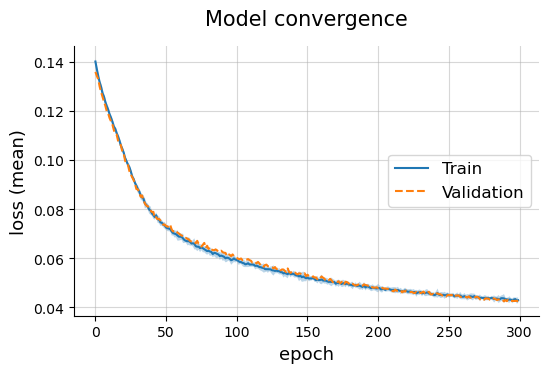

In [7]:
plotting.linePlot(
    train_info, valid_info,
    x='epoch', y='loss (mean)', err='loss (std)',
    labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
)

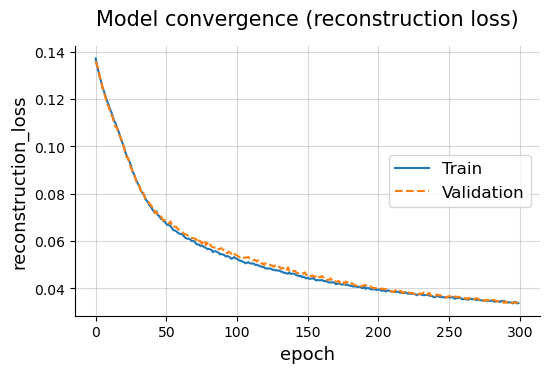

In [8]:
plotting.linePlot(
    train_info, valid_info,
    x='epoch', y='reconstruction_loss',
    labels=['Train', 'Validation'],
    title='Model convergence (reconstruction loss)',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
)

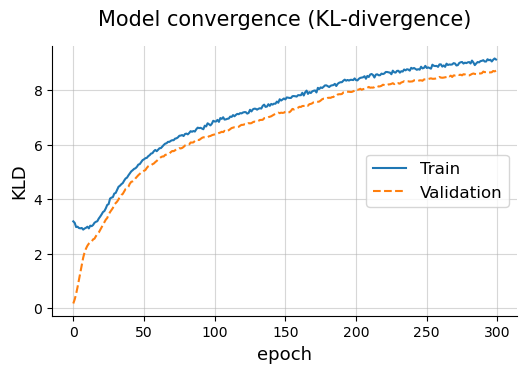

In [9]:
plotting.linePlot(
    train_info, valid_info,
    x='epoch', y='KLD',
    labels=['Train', 'Validation'],
    title='Model convergence (KL-divergence)',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
)

## Model evaluation

### Analyze the reconstruction error

In [10]:
np.random.seed(1999)
n_examples = 5

# select a random sample
X_test_ex = X_test[np.random.choice(np.arange(X_test.shape[0]), size=n_examples)]
X_train_ex = X_train[np.random.choice(np.arange(X_train.shape[0]), size=n_examples)]

# convert to torch Tensors
tX_test_ex = torch.Tensor(X_test_ex)
tX_train_ex = torch.Tensor(X_train_ex)

# reconstruct input
with torch.no_grad():
    r_tX_test_ex = model(tX_test_ex.to(device=DEVICE))[0]
    r_tX_train_ex = model(tX_train_ex.to(device=DEVICE))[0]
    
r_X_test_ex = r_tX_test_ex.squeeze(1).cpu().numpy()
r_X_train_ex = r_tX_train_ex.squeeze(1).cpu().numpy()

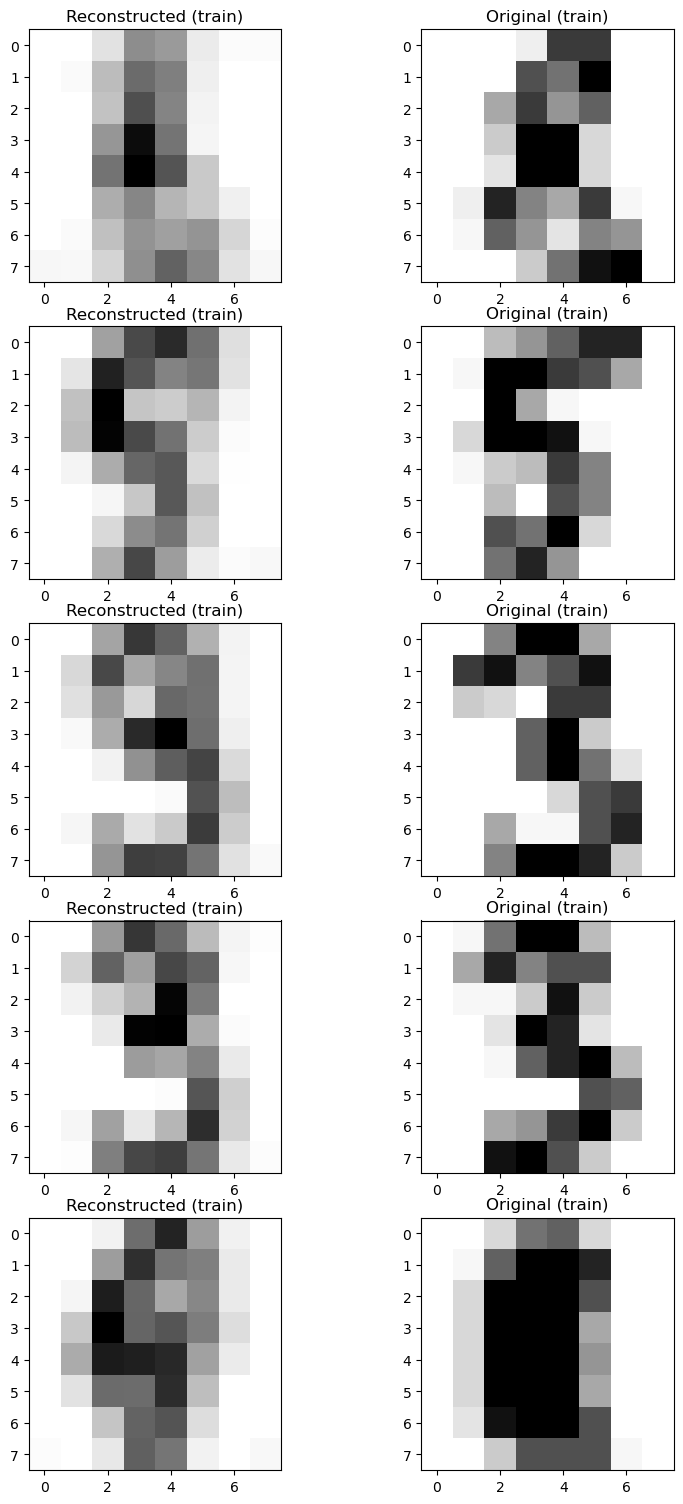

In [11]:
# display exapmles for the training data
fig, axes = plt.subplots(n_examples, 2, figsize=(8, 3*n_examples))
fig.tight_layout()
for i in range(len(axes)):
    for ii in range(len(axes[i])):
        ax = axes[i, ii]
        if ii == 0:
            ax.imshow(r_X_train_ex[i], cmap='Greys')
            ax.set_title('Reconstructed (train)')
        else:
            ax.imshow(X_train_ex[i].reshape(*X_train_ex[i].shape[1:]), cmap='Greys')
            ax.set_title('Original (train)')

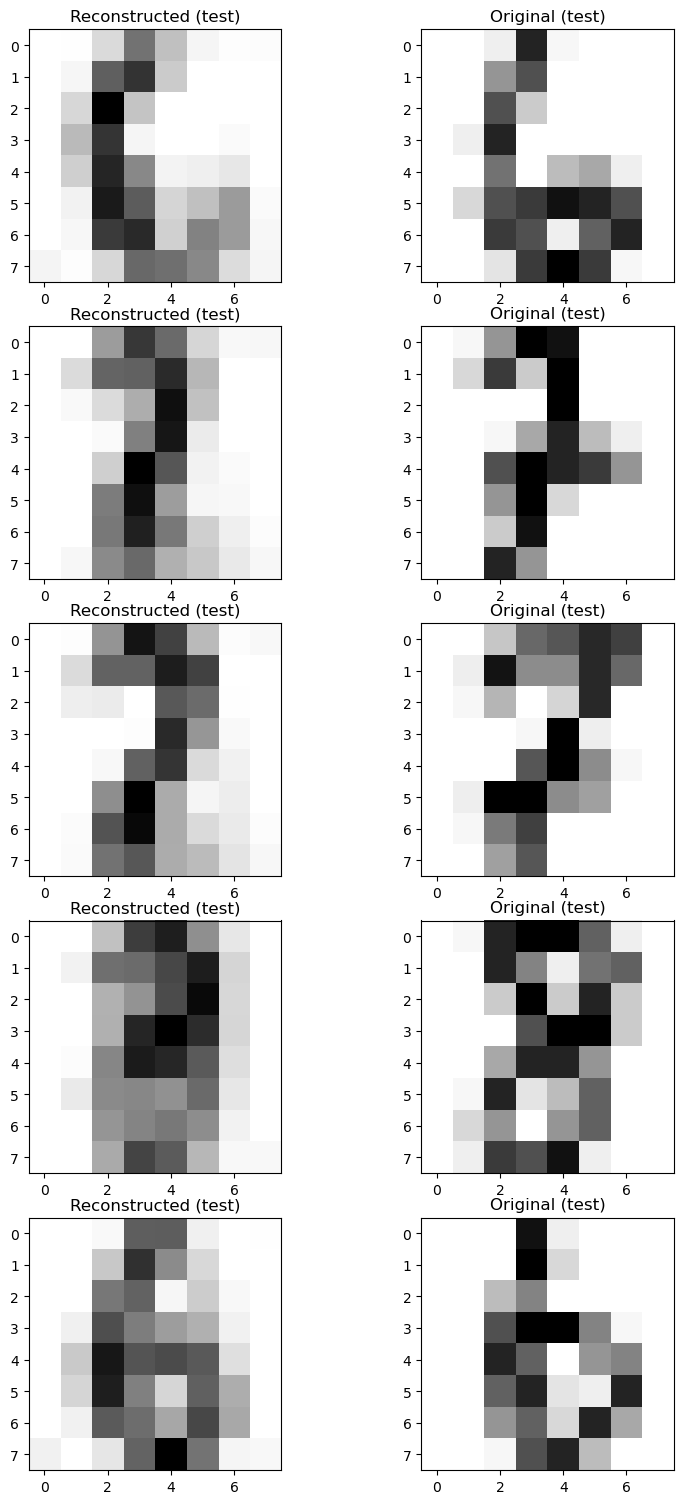

In [12]:
# display exapmles for the test data
fig, axes = plt.subplots(n_examples, 2, figsize=(8, 3*n_examples))
fig.tight_layout()
for i in range(len(axes)):
    for ii in range(len(axes[i])):
        ax = axes[i, ii]
        if ii == 0:
            ax.imshow(r_X_test_ex[i], cmap='Greys')
            ax.set_title('Reconstructed (test)')
        else:
            ax.imshow(X_test_ex[i].reshape(*X_test_ex[i].shape[1:]), cmap='Greys')
            ax.set_title('Original (test)')

### Compute regression metrics

In [13]:
# select all the data that are not in the training dataset
inference_X = np.concatenate([X_test, X_valid])
inference_labels = np.concatenate([labels_test, labels_valid])
t_inference_X = torch.Tensor(inference_X)

# reconstruct input
with torch.no_grad():
    rt_inference_X = model(t_inference_X.to(device=DEVICE))[0]
    
r_inference_X = rt_inference_X.squeeze(1).cpu().numpy()
inference_X = inference_X.reshape(inference_X.shape[0], *inference_X.shape[2:])

r_inference_X_flat = r_inference_X.reshape(r_inference_X.shape[0], -1)
inference_X_flat = inference_X.reshape(inference_X.shape[0], -1)

In [14]:
# compute regression metrics
pd.DataFrame([core.getScores(
    inference_X_flat,
    r_inference_X_flat,
    core.getDefaultMetrics('regression')
)]).round(decimals=4)

,explained_variance,mse,mae,r2,correlation
0,0.3672,0.0325,0.1148,0.3622,0.4999


### Visualize embedding dimensions

In [15]:
# generate model embeddings (using the mean vector)
with torch.no_grad():
    vae_emb = model.encode(t_inference_X.to(device=DEVICE))[0].cpu().numpy()

# project embeddings to 2d
emb2d = TSNE(n_components=2).fit_transform(vae_emb)

/home/fgarcia/anaconda3/envs/acespeech/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/fgarcia/anaconda3/envs/acespeech/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


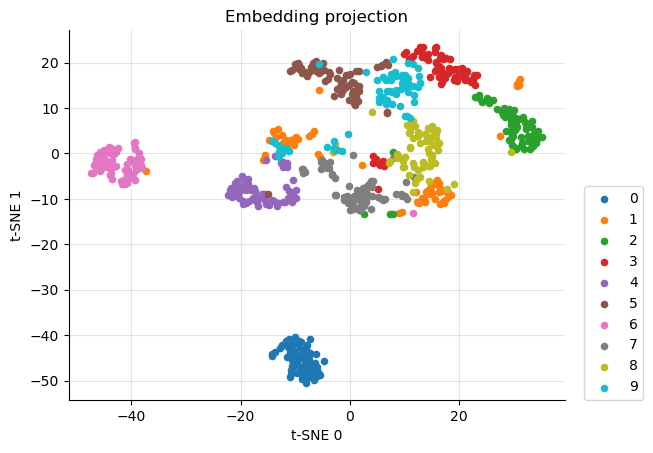

In [16]:
fig, ax = plt.subplots()
unique_labels = set(inference_labels)
for label in unique_labels:
    label_mask = inference_labels == label
    ax.scatter(
        emb2d[label_mask, 0],
        emb2d[label_mask, 1],
        label=label, s=20
    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Embedding projection')
ax.set_xlabel('t-SNE 0')
ax.set_ylabel('t-SNE 1')
ax.grid(alpha=0.2, color='grey')
ax.legend(loc=(1.04, 0))
plt.show()